### Stock Market Prediction and Forecasting Using Stacked LSTM

In [9]:
print("Pandas version:", pd.__version__)
# print("pandas_datareader version:", pdr.__version__)

Pandas version: 1.5.3


In [12]:
# collect stock data-- consider AAPL
import pandas as pd
!pip install yfinance --quiet

In [14]:
import yfinance as yf

In [204]:
df = yf.download('AAPL', start='2018-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed


In [206]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479832,40.489233,39.774854,39.986349,102223600
2018-01-03,40.472790,41.017975,40.409344,40.543288,118071600
2018-01-04,40.660786,40.764183,40.437543,40.545638,89738400
2018-01-05,41.123699,41.210645,40.665464,40.757111,94640000
2018-01-08,40.970974,41.267063,40.872274,40.970974,82271200


In [208]:
df.to_csv('AAPL.csv')

In [210]:
df=pd.read_csv('AAPL.csv') 


In [212]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,40.47983169555664,40.48923340934084,39.774853761275736,39.98634929298193,102223600
3,2018-01-03,40.4727897644043,41.01797452323995,40.40934432017212,40.54328828814392,118071600
4,2018-01-04,40.66078567504883,40.764183034424285,40.4375433322358,40.545637963798164,89738400


In [214]:
df=df.dropna()

In [216]:
df=df.drop(0)

In [218]:
df.head()

,Price,Close,High,Low,Open,Volume
2,2018-01-02,40.47983169555664,40.48923340934084,39.774853761275736,39.98634929298193,102223600
3,2018-01-03,40.4727897644043,41.01797452323995,40.40934432017212,40.54328828814392,118071600
4,2018-01-04,40.66078567504883,40.764183034424285,40.4375433322358,40.545637963798164,89738400
5,2018-01-05,41.12369918823242,41.21064529052004,40.66546440013252,40.7571113577525,94640000
6,2018-01-08,40.97097396850586,41.26706344560852,40.87227389043468,40.97097396850586,82271200


In [220]:
# Stock Prediction for Close Column 
df1 = df.reset_index()['Close']


In [222]:
df1

0        40.47983169555664
1         40.4727897644043
2        40.66078567504883
3        41.12369918823242
4        40.97097396850586
               ...        
1756    257.91644287109375
1757     258.7355041503906
1758    255.30929565429688
1759     251.9230194091797
1760     250.1449737548828
Name: Close, Length: 1761, dtype: object

In [224]:
df1.shape

(1761,)

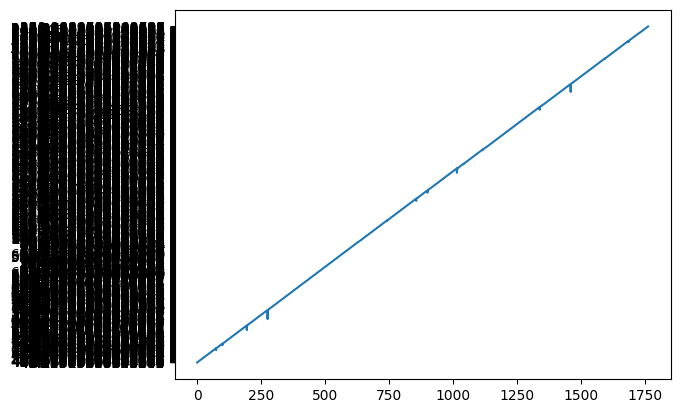

In [226]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [227]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [228]:
import numpy as np

In [229]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [230]:
df1.shape

(1761, 1)

In [231]:
df1

array([[0.02919923],
       [0.02916791],
       [0.03000412],
       ...,
       [0.98476023],
       [0.96969808],
       [0.96178934]])

In [232]:
# in timeseries data , next data is always dependent on previous data
# perform data division before data preprocessing
# splitting the dataset into train and test 
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [233]:
training_size,test_size

(1144, 617)

In [234]:
# Data Preprocessing
import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step), 0]   #i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
    


In [235]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [236]:
print(X_train)

[[0.02919923 0.02916791 0.03000412 ... 0.03986171 0.03802505 0.03641931]
 [0.02916791 0.03000412 0.03206315 ... 0.03802505 0.03641931 0.03663973]
 [0.03000412 0.03206315 0.03138383 ... 0.03641931 0.03663973 0.03597859]
 ...
 [0.54054767 0.54720073 0.57582677 ... 0.48418333 0.48852314 0.48690116]
 [0.54720073 0.57582677 0.5353389  ... 0.48852314 0.48690116 0.49996403]
 [0.57582677 0.5353389  0.53858253 ... 0.48690116 0.49996403 0.50741586]]


In [237]:
print(X_train.shape), print(y_train.shape)

(1093, 50)
(1093,)


(None, None)

In [238]:
print(X_test.shape), print(y_test.shape)

(566, 50)
(566,)


(None, None)

In [239]:
# Create a Stacked LSTM Model
# reshape input to be [samples, time steps, features] which is required for LSTM  --- into 3 dimensions
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [240]:
#Create the Stacked(one LSTM after the other) LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Input

In [241]:
model=Sequential()
model.add(Input(shape=(50, 1)))     
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))  #output
model.compile(loss='mean_squared_error',optimizer='adam')

In [242]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [259]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=110,batch_size=40,verbose=1)

Epoch 1/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0488 - val_loss: 0.0016
Epoch 2/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.5810e-04 - val_loss: 0.0016
Epoch 3/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.6023e-04 - val_loss: 0.0031
Epoch 4/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.5964e-04 - val_loss: 0.0024
Epoch 5/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.3573e-04 - val_loss: 0.0018
Epoch 6/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.7430e-04 - val_loss: 0.0018
Epoch 7/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.3432e-04 - val_loss: 0.0036
Epoch 8/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.6113e-04 - val_loss: 0.0021
Epoch 9/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.4286e-04 - val_loss: 0.0056
Epoch 10/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.3587e-04 - val_loss: 0.0032
Epoch 11/110
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.1991e-04 - val_loss: 0.0019
Epoch 12/110

In [268]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [270]:
##Transformback(by inverse scaling) to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

# Inverse transform y_train and y_test
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [272]:

### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))   #train_predict-- o/p for train data , calc RMSE for train dataset

# Now evaluate RMSE properly
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f"Corrected Train RMSE: {train_rmse}")
print(f"Corrected Test RMSE: {test_rmse}")

Corrected Train RMSE: 4.377800229634625
Corrected Test RMSE: 5.676360053649894


In [274]:

### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

189.77577605614943

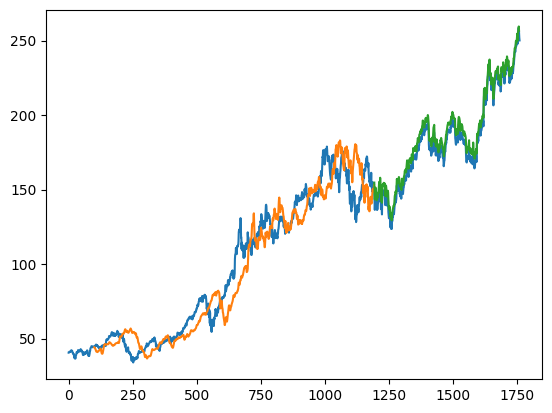

In [276]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
start = len(train_predict) + look_back
end = start + len(test_predict)

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[start:end, :] = test_predict

# plot
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [278]:
# Predict the furture 30 days 

In [280]:
len(test_data)

617

In [282]:
x_input=test_data[39:].reshape(1,-1)
x_input.shape

(1, 578)

In [284]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()  #converting into a list

In [286]:
temp_input

[0.5308928030884048,
 0.517987392271658,
 0.5106567746857231,
 0.5272494166482283,
 0.5378723915454376,
 0.5239133503734945,
 0.5196117503810961,
 0.5094716780848416,
 0.5109641627222269,
 0.5153096752912687,
 0.5068817183866777,
 0.4745743466392287,
 0.4557868224262276,
 0.47444260890929846,
 0.49046472673074604,
 0.49178149319049647,
 0.48752353429049633,
 0.46408317734301086,
 0.46553174940375275,
 0.4592107817253095,
 0.45640139488605125,
 0.47681300572424534,
 0.4565770451926249,
 0.4742670943448475,
 0.48014907199897927,
 0.480631974599934,
 0.47856883007936846,
 0.49560052993724646,
 0.505169806608198,
 0.5178557224127891,
 0.5047309523260092,
 0.4847582636410652,
 0.5327803651734581,
 0.5222453511716582,
 0.5104372796735673,
 0.48576777780643443,
 0.45877185957205935,
 0.4575846589682785,
 0.4599589923047791,
 0.4625091116899759,
 0.4421516619586774,
 0.49491414989459626,
 0.5073573587840764,
 0.5011136283733615,
 0.5088522189086062,
 0.5033560882378093,
 0.5118422106419109,
 0

In [288]:
from numpy import array

lst_output = []
n_steps = 50
i = 0

while i < 30:
    # Always use the last n_steps values for prediction
    x_input = np.array(temp_input[-n_steps:])

    # Only predict if we have enough values to reshape properly
    if len(x_input) == n_steps:
        print(f"{i} day input: {x_input}")
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(f"{i} day output: {yhat}")

        # Extend input and output lists
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i += 1
    else:
        print(f"Not enough data to reshape. Needed: {n_steps}, Got: {len(x_input)}")
        break

print(lst_output)


0 day input: [0.89869762 0.89594593 0.87331093 0.8724677  0.87619579 0.88502785
 0.88622618 0.87038175 0.85178555 0.83847088 0.8344764  0.84086747
 0.83762758 0.85875353 0.85755391 0.8454242  0.8454242  0.84937857
 0.86315226 0.84884538 0.86226362 0.86341879 0.86661782 0.86448518
 0.87048335 0.88381268 0.89354309 0.8929655  0.903629   0.91367039
 0.92726632 0.92886583 0.92899913 0.9281105  0.94548311 0.95001507
 0.94432788 0.95085932 0.95161458 0.96454402 0.9753852  0.95125914
 0.95899013 0.97987284 0.98333847 0.99635682 1.         0.98476023
 0.96969808 0.96178934]
0 day output: [[0.9702742]]
1 day input: [0.89594593 0.87331093 0.8724677  0.87619579 0.88502785 0.88622618
 0.87038175 0.85178555 0.83847088 0.8344764  0.84086747 0.83762758
 0.85875353 0.85755391 0.8454242  0.8454242  0.84937857 0.86315226
 0.84884538 0.86226362 0.86341879 0.86661782 0.86448518 0.87048335
 0.88381268 0.89354309 0.8929655  0.903629   0.91367039 0.92726632
 0.92886583 0.92899913 0.9281105  0.94548311 0.9500

In [290]:
day_new=np.arange(1,51)  #previous 50 days
day_pred=np.arange(51,81)  #30 days future we have to predict

In [292]:
import matplotlib.pyplot as plt

In [294]:
len(df1)

1761

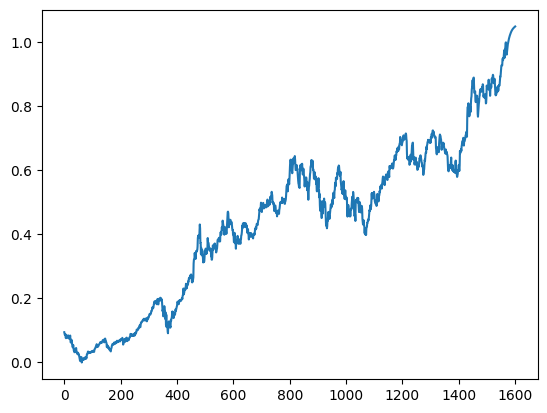

In [296]:
# Combine df1 and lst_output
# df3 = df1.tolist()
# df3.extend(lst_output)

# # Convert df3 to a 1D NumPy array
# df3 = np.array(df3).flatten()

# # Plot the last portion of df3
# plt.plot(df3[190:])
# plt.show()

# Flatten df1 (if it's a 2D array) and lst_output
df1_flat = df1.flatten()  # flatten df1 if it's 2D
lst_output_flat = np.array(lst_output).flatten()  # flatten lst_output

# Combine the two
df3 = np.concatenate((df1_flat, lst_output_flat))

# Plot the last portion of df3
plt.plot(df3[190:])
plt.show()


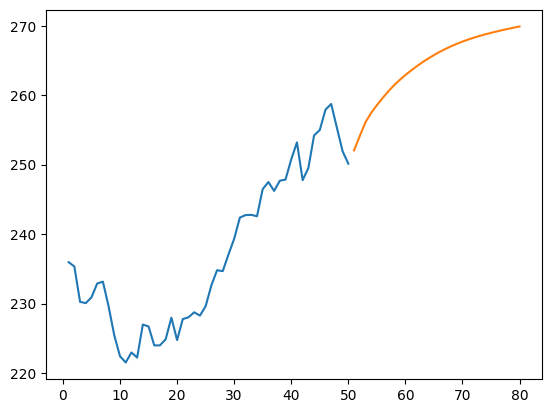

In [300]:
# Reshape lst_output to a 2D array before inverse transforming
lst_output_reshaped = np.array(lst_output).reshape(-1, 1)

# Plotting
# plt.plot(day_new, scaler.inverse_transform(df1[202:]))  #taking previous 50 data
# plt.plot(day_pred, scaler.inverse_transform(lst_output_reshaped))
# plt.show()
plt.plot(day_new, scaler.inverse_transform(df1[-50:]))  # using the last 50 data points
plt.plot(day_pred, scaler.inverse_transform(lst_output_reshaped))
plt.show()